# Codon position (CP) mutation bar charts

This notebook says "histogram" a lot, but ... really these are bar charts. The Marcus who wrote this notebook a few months ago was such an innocent young lad.

In [1]:
%run "Header.ipynb"
%run "GeneUtils.ipynb"

In [2]:
import pileup
seq2pos2pileup = pileup.load()

In [3]:
from parse_sco import parse_sco

In [35]:
def get_ylabel(normalize=False):
    if normalize:
        return r"$\dfrac{\mathrm{Number\ of\ Mutated\ Positions}}{\mathrm{Number\ of\ Positions}}$"
    else:
        return "Number of Mutated Positions"
        

def histogram_of_123(vals, title, axes, xlabel="Codon Position", ylabel=get_ylabel(),
                     format_yaxis="thousands", max_val=None, show_ylabel=True, show_xlabel=True):
    if len(vals) == 3:
        one, two, three = vals
        x = [1, 2, 3]
        labels = ["1", "2", "3"]
    elif len(vals) == 4:
        one, two, three, four = vals
        x = [1, 2, 3, 4]
        labels = ["1", "2", "3", "Non-Coding"]
    else:
        raise ValueError("Not 3 or 4 vals passed?")
    axes.bar(
        x=x,
        height=vals,
        color=[cp2color[i + 1] for i in range(len(vals))],
        edgecolor=BORDERCOLOR,
        tick_label=labels
    )
    
    if max_val is None:
        ypad = 0.04 * max(vals)
    else:
        ypad = 0.04 * max_val
    # to make interpreting the plots easier, show text for each bar
    # just above it: https://stackoverflow.com/a/30229062
    # and https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh/30229062#comment86813015_30229062
    for xi, yval in enumerate(vals, 1):
        # Used to make decision about normalized vs unnormalized values
        if format_yaxis == "percentages":
            text = f"{(yval * 100):.3f}%"
        else:
            text = f"{yval:,}"
        axes.text(xi, yval + ypad, text, ha="center")
        
    print(title, vals)
    if three > one and one > two:
        axes.set_title(title, fontsize=15)
    else:
        axes.set_title(title, color="#cc3322", fontweight="semibold", fontsize=15)
            
    if show_xlabel:
        axes.set_xlabel(xlabel, fontsize=20)
    if show_ylabel:
        axes.set_ylabel(ylabel)
        
    if format_yaxis == "thousands":
        use_thousands_sep(axes.get_yaxis())
    elif format_yaxis == "percentages":
        # Make the y-axis show percentages: based on
        # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
        # (This is duplicated within this notebook... TODO, make this a function like use_thousands_sep()?)
        axes.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=2))
    else:
        raise ValueError("Unrecognized format_yaxis value: {}".format(format_yaxis))
        
    # Shoddy way to add padding -- see https://stackoverflow.com/a/42804403
    max_yval_pad = 1.2
    if max_val is None:
        max_val = max(vals)    
    axes.set_ylim(0, max_val * max_yval_pad)
    
    # Make ticks bigger: https://stackoverflow.com/a/11386056
    axes.tick_params(axis='x', which='major', labelsize=12)
    # axes.tick_params(axis='y', which='major', labelsize=10)

def histogram_maker(
    p,
    title,
    axes,
    ylabel=get_ylabel(),
    normalize=False,
    add_noncoding_col=True,
    make_yaxes_comparable=False,
    show_xlabel=True,
    show_ylabel=True,
    already_done_calls=None,
):
    """
    Produces histograms of pileup data for the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    p: float
        In the range [0, 50]. Threshold to use for naive p-mutation calling. If already_done_calls is specified,
        this parameter will be ignored, so I suggest setting it to None in that case.
        Ordinarily, naive p-mutation calling can only be done with p in the range (0, 50] -- i.e. p = 0% doesn't
        make sense, since we use >= p when calling a mutation, so p = 0% implies that every position is a
        p-mutation. Before we used >= p, we used > p, so p = 0% was useful as a way of saying "if there are ANY
        non-matching nucleotides then call this a mutation". We replicate this here: if you pass p = 0 exactly,
        we'll use pileup.any_mismatches() instead of pileup.naively_call_mutation().
        
    title: str
        Will be included after the seq name in every histogram. For example, if this is "blah blah",
        then each histogram will say "CAMP: blah blah", "BACT1: blah blah", etc. as their titles.
        If this is just an empty string (""), then the colon and space will be omitted -- so the titles
        will just be "CAMP", "BACT1", etc.
        
    ylabel: str
        Label for the y-axis of the histogram. Only will be used if normalize is False.
        There's a chance this being a function parameter is now entirely pointless.
        
    normalize: bool
        If True, divides each 1/2/3 value by (number of positions considered). This makes it easier to compare
        histograms between different sequences.
        This also sets ylabel to "Number of Mutated Positions / Number of Positions", ignoring whatever
        ylabel's default was (or even ignoring the already-specified ylabel).
        
    add_noncoding_col: bool
        If True, adds a 4th column to each histogram representing all of the positions not contained within
        predicted protein-coding genes. If normalize is True, this column's value is divided by the total number
        of these positions, so it's also a percentage.
        
    make_yaxes_comparable: bool
        If True, sets the ylim max to just over the max y-value across all seqs' plots (so the y-range is the
        same for each row). Could be useful, could be bad if the values wildly differ btwn seqs (in which case
        the seqs with lower values could be hard to read)
        
    show_xlabel: bool
        If True, an x-axis label will be shown for the middle sequence's histogram.
    
    show_ylabel: bool
        If True, a y-axis label will be shown for the left sequence's histogram.
        
    already_done_calls: dict or None
        If you pass this, it should map sequence names (e.g. "edge_6104") to 1-indexed positions that have
        already-made calls in this sequence (e.g. as produced by an external variant calling tool like
        LoFreq). These calls will be used to generate the histogram.
        
        If this argument is passed, the "p" parameter will be ignored since this function won't actually do
        any "calling."
    """
    def call_func(seq, pos):
        # Only call "rare" mutations, as determined by the pileup module.
        if already_done_calls is None:
            if p != 0:
                if pileup.naively_call_mutation(seq2pos2pileup[seq][pos], p, only_call_if_rare=True):
                    return 1
                return 0
            else:
                # We could totally handle this with any_mismatches(), but it's unclear how to merge that
                # with the whole "exclude this mutation if it is 'rare'" condition we now apply using
                # naively_call_mutation(). Like, we could make this work, but this is currently unused so
                # for now we just raise an error. If you're reading this comment because this just gave
                # you an error in this location, hit me up and I'll see what I can do.
                raise ValueError("p = 0% is currently unsupported. see notebook comment for reason.")
                #if pileup.any_mismatches(seq2pos2pileup[seq][pos]):
                #    return 1
                #return 0
        else:
            if pos in already_done_calls[seq] and pileup.is_position_rare(seq2pos2pileup[seq][pos]):
                return 1
            return 0
            
    if normalize:
        ylabel = get_ylabel(normalize=True)
    seq2vals = {}
    max_val = 0
    for seq in SEQS:
        df = parse_sco(f"../seqs/genes/{seq}.sco")
        
        # Identify multi-gene positions in advance, so we can purposefully NOT count these towards the CP
        # mutation rates in the plots.
        pos_to_genes = get_parent_gene_info_of_many_positions(df)

        # Mutation rates at modulo positions 1, 2, 3 in a gene within the genome (goes 1, 2, 3, 1, 2, 3, ...)
        m1 = []
        m2 = []
        m3 = []
        total_gene_length = 0
        bases_in_genes = set()
        for gene in df.itertuples():
            cp = 1
            gm1 = []
            gm2 = []
            gm3 = []
            
            # This'll account for the strand of the gene (left -> right if the strand is +, right -> left if
            # the strand is -. So, in any case, we can just take the CP from 1,2,3,1,2,3,1,2,3,...)
            pos_interval = get_pos_interval_from_gene(gene)
            total_gene_length += len(pos_interval)
            bases_in_genes |= set(pos_interval)
            for pos in pos_interval:
                
                is_singlegene_pos = True
                
                if len(pos_to_genes[pos]) > 1:
                    # Ignore positions that are located in overlapping regions between multiple genes
                    is_singlegene_pos = False
                    
                elif len(pos_to_genes[pos]) == 0:
                    # But... we know this position is already in this gene......?
                    raise ValueError("Something has gone horrendously wrong")
                    
                if is_singlegene_pos:
                    val = call_func(seq, pos)
                    if cp == 1:
                        gm1.append(val)
                    elif cp == 2:
                        gm2.append(val)
                    elif cp == 3:
                        gm3.append(val)
                    else:
                        raise ValueError("Marcus forgot how modulos work, go yell at him pls")
                        
                # Update the CP independently of whether or not this position was in a single gene!
                cp = next_cp(cp)

            if cp != 1:
                raise ValueError("Gene length not divisible by 3.")
                
            m1 += gm1
            m2 += gm2
            m3 += gm3
        
        mutation_vals = [m1, m2, m3]
        if add_noncoding_col:
            mn = []
            # Figure out which bases are not in any genes. Computing a set of a range is a pretty inefficient
            # way to do this, probably, but it works and is easy to reason about so i'll take it :P
            bases_not_in_genes = set(range(1, seq2len[seq] + 1)) - bases_in_genes
            for pos in bases_not_in_genes:
                val = call_func(seq, pos)
                mn.append(val)
            mutation_vals.append(mn)

        # Set vals to just the number of mutations in each pos in mutation_vals
        vals = [sum(m) for m in mutation_vals]
        
        if normalize:
            format_yaxis = "percentages"
            # Divide, to get (# mutated positions) / (# positions considered)
            # Note that we DON'T divide by just gene length / 3 (which would work for CP 1/2/3). Two reasons
            # for this:
            # 1. Overlapping genes can mess with this (e.g. if there's an overlap of 1 base at the end of a
            #    forward-strand gene, then this will cause this gene to have one less CP3 position than CP1 and
            #    CP2; the overlapping gene, depending on its strand, might also have one less CP3 position,
            #    or one less CP1 position. In any case, stuff gets messed up if we assume the counts are exactly
            #    the same in CP1, CP2, and CP3.
            # 2. For non-coding positions (if we're adding a 4th col for these), this doesn't make sense!
            for i in range(len(vals)):
                num_total_positions = len(mutation_vals[i])
                vals[i] /= num_total_positions
        else:
            format_yaxis = "thousands"
            
        max_val = max(max_val, max(vals))
        seq2vals[seq] = vals

    # Delay creating a histogram for a given genome until we've computed values for all of the genomes --
    # this lets us be fancy and set all histograms in a row to the same max value on the y-axis if needed
    i = 0
    for seq in SEQS:
        if not make_yaxes_comparable:
            max_val = None
        if title != "":
            seqtitle = "{}: {}".format(seq2name[seq], title)
        else:
            seqtitle = seq2name[seq]
        histogram_of_123(seq2vals[seq], seqtitle, axes[i],
                         ylabel=ylabel, format_yaxis=format_yaxis, max_val=max_val,
                         show_ylabel=(i == 0) and show_ylabel, show_xlabel=(i == 1) and show_xlabel)
        i += 1
        
        
def histogram_matrix_maker(
    adc_info, percentage_thresholds, normalize=False, make_yaxes_comparable=False, figfilename=None
):
    """Exactly what it says on the tin. Creates a "matrix" of rows of the CP 1/2/3/NC plots.
    
    This is set up so that it'll take two main lists / collections of values:
    
    adc_info is a collection of 2-tuples. Each 2-tuple should contain:
    Entry 0: A name (e.g. "LoFreq") that'll be passed as the "title" to histogram_maker().
    Entry 1: An "already_done_calls" object that'll be passed directly to histogram_maker().
    
    adc_info is intended to make it easy to include external variant calling tools' results in this matrix.
    
    percentage_thresholds is a list of percentages (numbers in the range (0, 50]) that'll be passed to
    histogram_maker() to use as thresholds for naive calling.
    
    So the already done calls will be placed on their own row(s) at the top of the matrix, then the percentage
    naive calling will take up the rows below that.
    """
    num_rows = len(adc_info) + len(percentage_thresholds)
    fig, axes = pyplot.subplots(
        num_rows,
        3,
        gridspec_kw={"hspace": 0.7, "wspace": 0.35}
    )
    
    def get_hm_params(row):
        return {
            "axes": axes[row, :],
            "show_xlabel": (row == num_rows - 1),
        }
        
    row = 0
    
    for call_details in adc_info:
        
        params = get_hm_params(row)
        histogram_maker(
            None,
            call_details[0],
            normalize=normalize,
            make_yaxes_comparable=make_yaxes_comparable,
            axes=params["axes"],
            show_xlabel=params["show_xlabel"],
            show_ylabel=False,
            already_done_calls=call_details[1],
        )
        row += 1
        
    for p in percentage_thresholds:
        
        params = get_hm_params(row)
        if p != 0:
            # do some unicode sorcery to get a fancy i with two dots overhead
            # turns out this works the same as it does in ggplot2 in R :O
            title_suffix = f"na\u00efve, $p$ = {str(p)}%"
        else:
            title_suffix = "alt(pos) > 0"
        histogram_maker(
            p,
            title_suffix,
            normalize=normalize,
            make_yaxes_comparable=make_yaxes_comparable,
            axes=params["axes"],
            show_xlabel=params["show_xlabel"],
            show_ylabel=False,
        )
        row += 1
    
    # Slap the y-axis label in a constant location; this way it'll be centered regardless of if the number
    # of rows is even or odd. These coordinates chosen based on trial and error.
    #
    # The ylabel_xpos thing is because the y-axis label when using normalization is a fraction, so it takes
    # up some extra horizontal space (so it should be pushed to the left a bit to fit); and the _ypos thing
    # is due to the title being taller for the normalized plot, i think
    ylabel_xpos = 0.075 if not normalize else 0.035
    ylabel_ypos = 0.36 if not normalize else 0.365
    
    fig.text(
        ylabel_xpos, ylabel_ypos, get_ylabel(normalize=normalize),
        rotation=90, fontsize=20, color="#6b6b6b"
    )
    
    title = "Rare mutation frequencies across codon positions"
    titley = 0.93
    if normalize:
        title += "\n(each bar normalized by total number of positions in that category)"
        # a bit extra y space to account for extra line
        titley += 0.025
    fig.suptitle(title, y=titley, x=0.52, fontsize=24)
    fig.set_size_inches(15, 15)
    if figfilename is not None:
        fig.savefig("figs/{}".format(figfilename), bbox_inches="tight")

## Values of _p_ to consider: 2%, 1%, 0.5%, 0.25%, 0.15%, ~~0.1%, 0.05%, 0%~~

Note that, if used, 0% will be handled specially; see `pileup.any_mismatches()` for details.

In [5]:
percentages = [2, 1, 0.5, 0.25, 0.15]

## Load LoFreq variant calls

In [6]:
from pysam import VariantFile

In [7]:
lofreq_calls = VariantFile("../seqs/lofreq.vcf")
# We store the (1-indexed) positions that have variants as sets for each sequence, not lists. This is because
# lookup is a lot faster in sets (avg O(1)) than in lists (avg O(n)), and we repeatedly do lookup in
# histogram_maker(). This could maybe be made MORE efficient by storing the positions in sorted order (I think
# VCF guarantees the positions are already sorted) and then using binary search to check if a position has a
# variant associated with it, but not sure that's necessary at this point at least.
#
# A nice side effect of this (which I realized a few days later) is that this automatically means that multiple
# variants called at a single position will just be counted as a single variant call, which is what I'd intend
# to happen anyway.
seq2lofreq_calls = {s: set() for s in SEQS}

for c in lofreq_calls.fetch():
    seq2lofreq_calls[c.contig].add(c.pos)

for seq in SEQS:
    print(f"{seq2name[seq]} had {len(seq2lofreq_calls[seq]):,} variants called by LoFreq.")

CAMP had 57 variants called by LoFreq.
BACT1 had 16,131 variants called by LoFreq.
BACT2 had 84 variants called by LoFreq.


[W::vcf_parse] Contig 'edge_1671' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'edge_2358' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig 'edge_6104' is not defined in the header. (Quick workaround: index the file with tabix.)


## Generate histogram matrix without normalization (so the y-axis is just # of mutated positions)

CAMP: LoFreq [7, 4, 11, 0]
BACT1: LoFreq [1487, 961, 6179, 1009]
BACT2: LoFreq [11, 8, 12, 48]
CAMP: naïve, $p$ = 2% [5, 3, 8, 1]
BACT1: naïve, $p$ = 2% [1635, 1083, 6287, 1510]
BACT2: naïve, $p$ = 2% [17, 12, 19, 52]
CAMP: naïve, $p$ = 1% [10, 9, 15, 14]
BACT1: naïve, $p$ = 1% [2412, 1616, 9060, 2053]
BACT2: naïve, $p$ = 1% [67, 52, 74, 161]
CAMP: naïve, $p$ = 0.5% [50, 52, 82, 65]
BACT1: naïve, $p$ = 0.5% [2759, 1857, 10029, 2414]
BACT2: naïve, $p$ = 0.5% [366, 301, 426, 497]
CAMP: naïve, $p$ = 0.25% [404, 395, 479, 373]
BACT1: naïve, $p$ = 0.25% [4120, 3213, 12037, 3769]
BACT2: naïve, $p$ = 0.25% [1643, 1406, 1869, 2104]
CAMP: naïve, $p$ = 0.15% [1858, 1735, 2120, 1248]
BACT1: naïve, $p$ = 0.15% [9004, 8330, 17535, 6840]
BACT2: naïve, $p$ = 0.15% [5546, 4998, 5838, 7096]


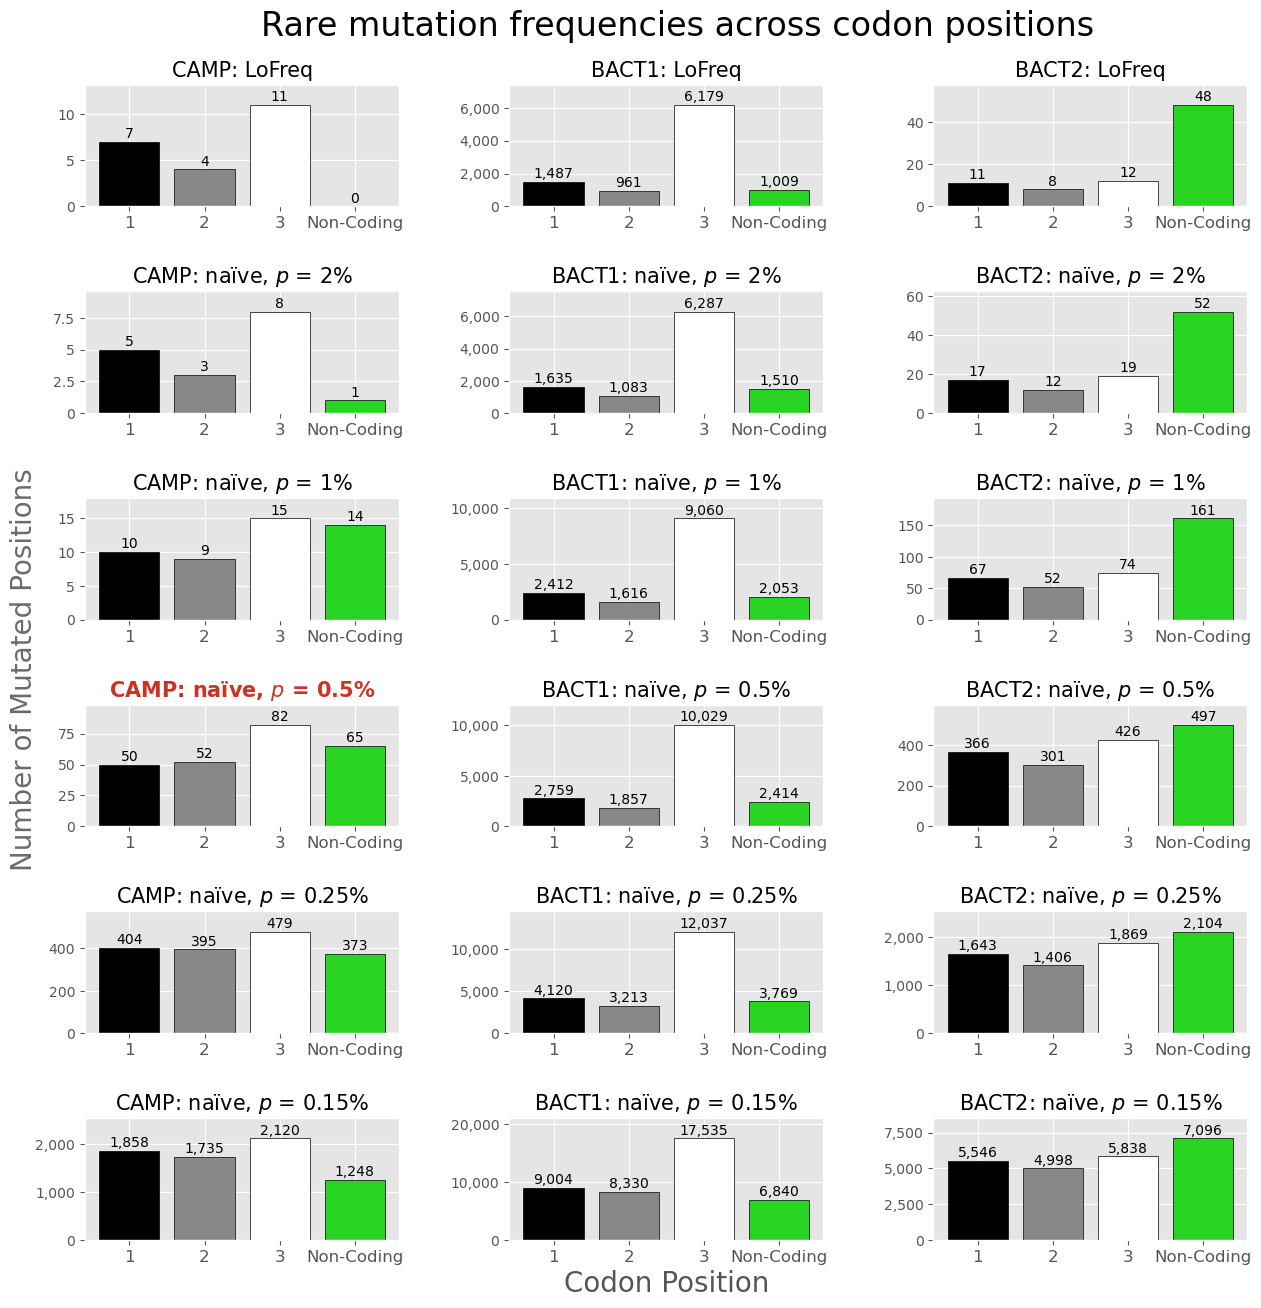

In [26]:
histogram_matrix_maker(
    [("LoFreq", seq2lofreq_calls)],
    percentages,
    figfilename="unnormalized-cp-hists.pdf"
)

## Generate histogram matrix with normalization, and making y-axes comparable for each row

CAMP: LoFreq [1.773435956160663e-05, 1.013042927694061e-05, 2.787025635568528e-05, 0.0]
BACT1: LoFreq [0.0022948770381116266, 0.0014829491707984007, 0.00953618549493559, 0.00485984009247664]
BACT2: LoFreq [1.4456070629732721e-05, 1.0515357679891481e-05, 1.5771046461502877e-05, 9.354828650721881e-05]
CAMP: naïve, $p$ = 2% [1.266739968686188e-05, 7.597821957705458e-06, 2.0269277349589294e-05, 9.911490390810066e-06]
BACT1: naïve, $p$ = 2% [0.0025232844366593877, 0.0016712111883191135, 0.009702864250956473, 0.007272902417878817]
BACT2: naïve, $p$ = 2% [2.2341200064132387e-05, 1.5773036519837223e-05, 2.497082356404622e-05, 0.00010134397704948705]
CAMP: naïve, $p$ = 1% [2.533479937372376e-05, 2.2793465873116374e-05, 3.8004895030479924e-05, 0.00013876086547134092]
BACT1: naïve, $p$ = 1% [0.003722423279035133, 0.0024937001665038664, 0.013982495643974177, 0.00988825739331471]
BACT2: naïve, $p$ = 1% [8.805061201746294e-05, 6.834982491929464e-05, 9.725478651260106e-05, 0.0003137765443262964]
CAMP

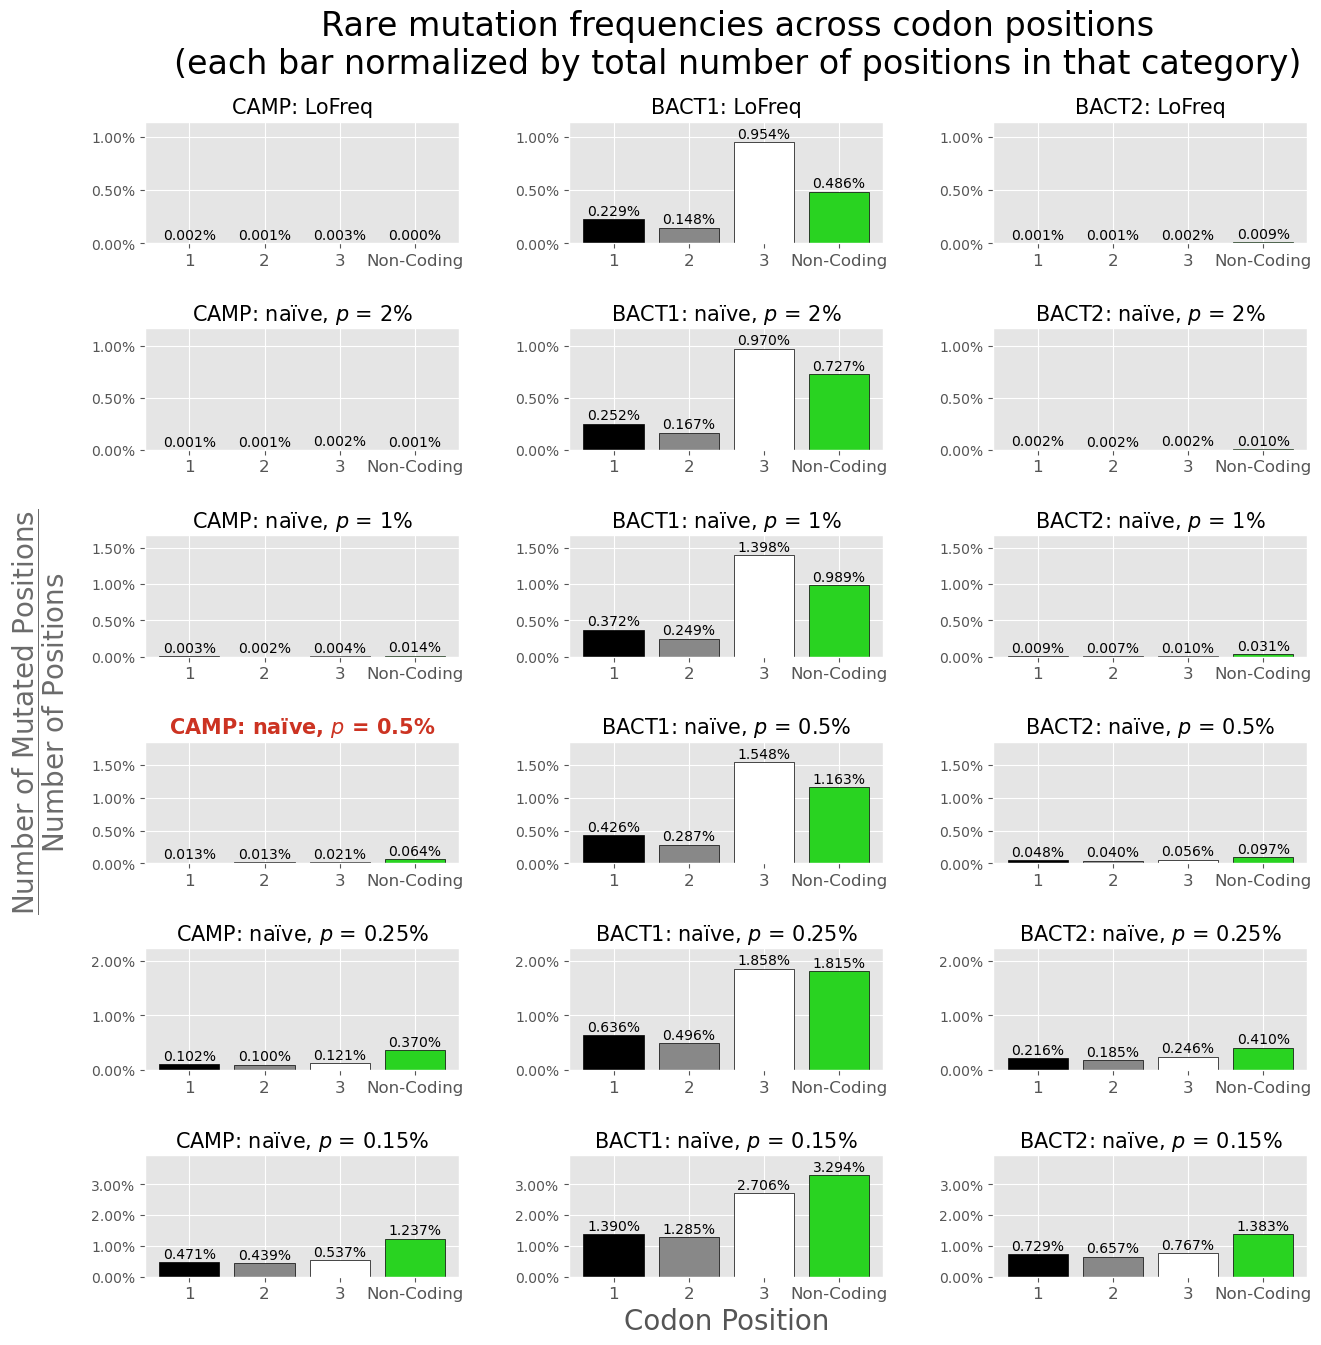

In [36]:
histogram_matrix_maker(
    [("LoFreq", seq2lofreq_calls)],
    percentages,
    normalize=True,
    make_yaxes_comparable=True,
    figfilename="normalized-cp-hists.pdf"
)